# SNA

In [1]:
# automatically reload imports before executing any line in case you changed something
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import read_graph
import viz
import utils

In [3]:
all_postings = utils.read_all_postings()
all_votes = utils.read_all_votes()
all_postings.shape, all_votes.shape

((739094, 14), (3824984, 8))

## Show Inland comments network

Idea:
- 1: get community of people interested in Inland articles
  - Interest = any interaction on any Inland article ever 
  - maybe set some lower boundary (eg >= 10 interactions total)
- 2: for each day plot interactions between those users 
  - as graph with 1 node per user and an edge betwween users if there was at least 1 interaction on that day
  - Edge width = number of interactions between these users on that day
  - how to view so many plots in a sensible fashion?
- 3: calculate some metrics for each day and plot as line plot
  - total number of interactions
  - num interactions / interacting users to account for changing user numbers
  - others like connectedness / etc. ?

### show users with most interactions in Inland postings over the entire time frame

info: note the minimum threshold for displaying an edge (here 25) and the scale on the right for comparing between days

In [34]:
# Ibiza Artikel ist unter "Meinung", aber anderer Strache Artikel (Inland) am selben Tag hat eh ~5 mal mehr postings also bleib ich mal bei Inland
postings_inl = all_postings.query("ArticleChannel == 'Inland'")

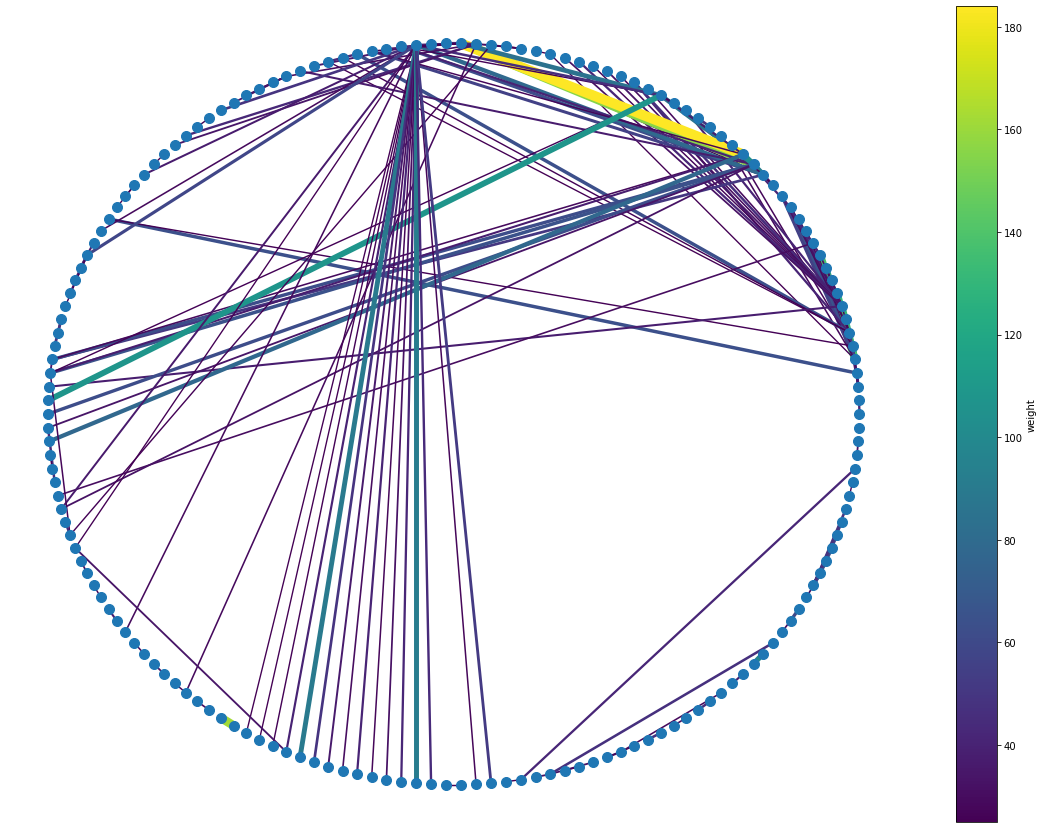

In [35]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_inl, all_votes, 25)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=100, pos=nx.circular_layout(G_int_w))

### compare strache day with day before / after

In [36]:
postings_inl_0 = postings_inl.query("'2019-05-17' <= PostingCreatedAt & PostingCreatedAt < '2019-05-18'")
votes_0 = all_votes.query("'2019-05-17' <= VoteCreatedAt & VoteCreatedAt < '2019-05-18'")

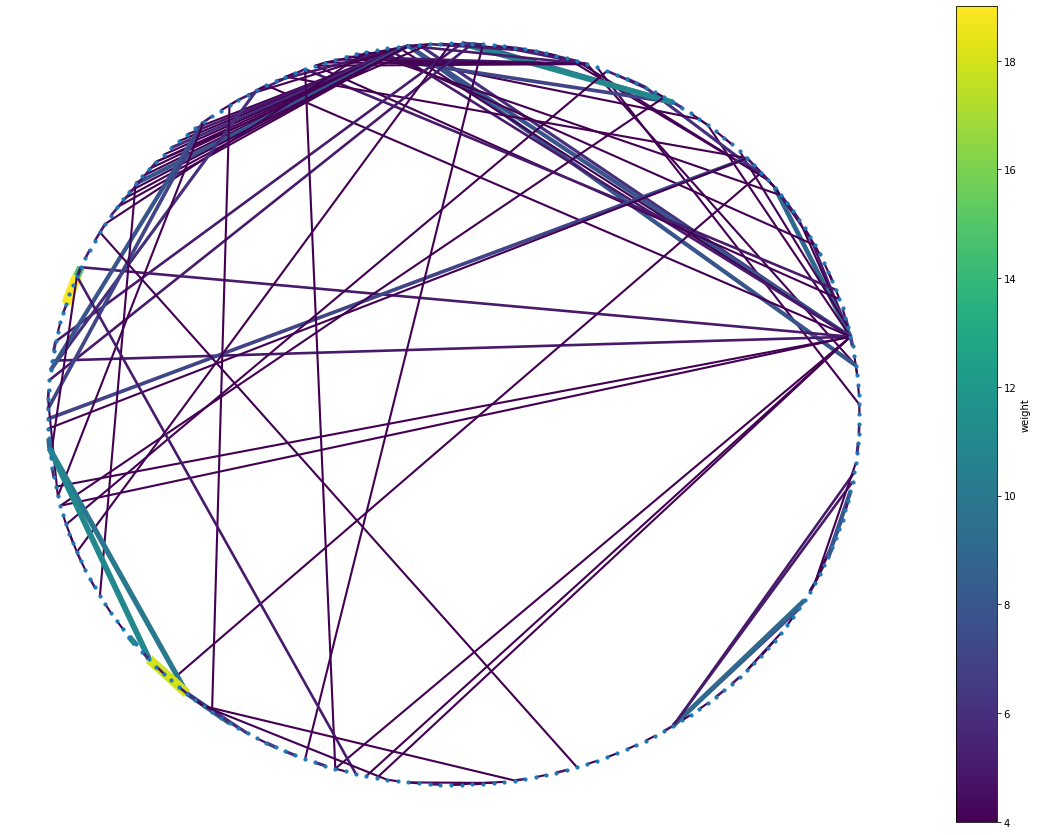

In [37]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_inl_0, votes_0, 4)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=10, pos=nx.circular_layout(G_int_w))

#### day before

In [38]:
postings_inl_b = postings_inl.query("'2019-05-16' <= PostingCreatedAt & PostingCreatedAt < '2019-05-17'")
votes_b = all_votes.query("'2019-05-16' <= VoteCreatedAt & VoteCreatedAt < '2019-05-17'")

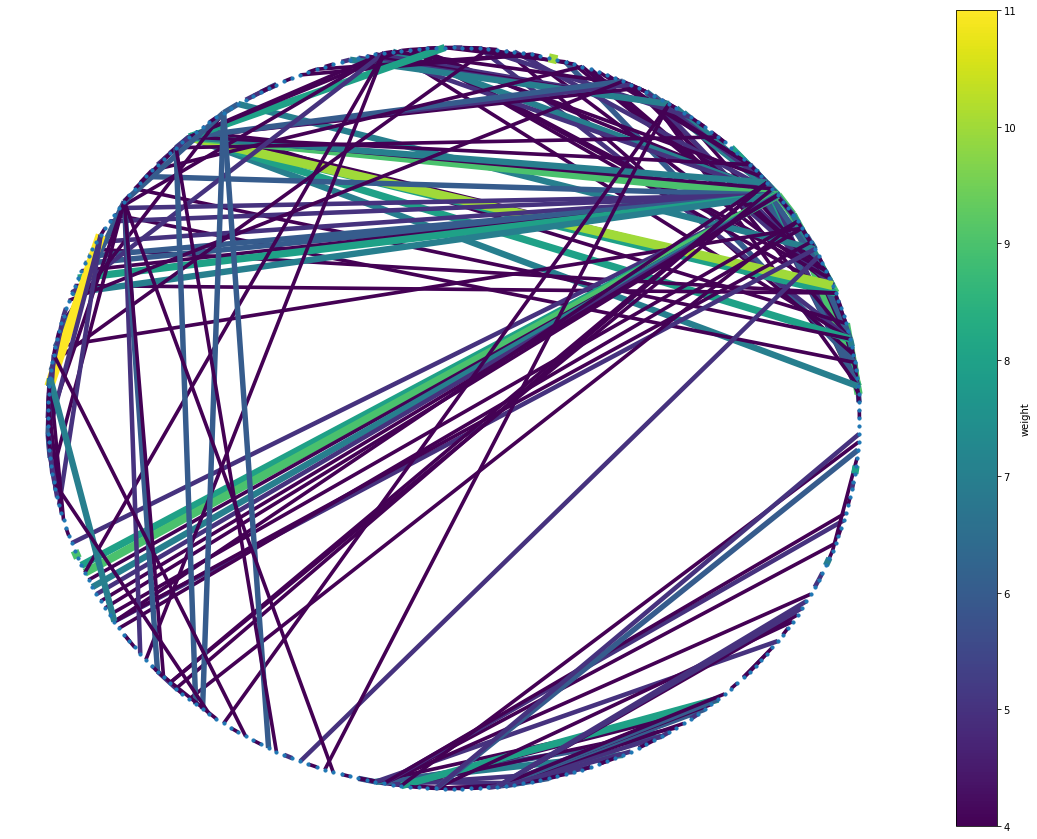

In [39]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_inl_b, votes_b, 4)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=10, pos=nx.circular_layout(G_int_w))

a bit more than on strache day (scale only goes to 11 compared to 17 above)

#### day after

In [40]:
postings_inl_a = postings_inl.query("'2019-05-18' <= PostingCreatedAt & PostingCreatedAt < '2019-05-19'")
votes_a = all_votes.query("'2019-05-18' <= VoteCreatedAt & VoteCreatedAt < '2019-05-19'")

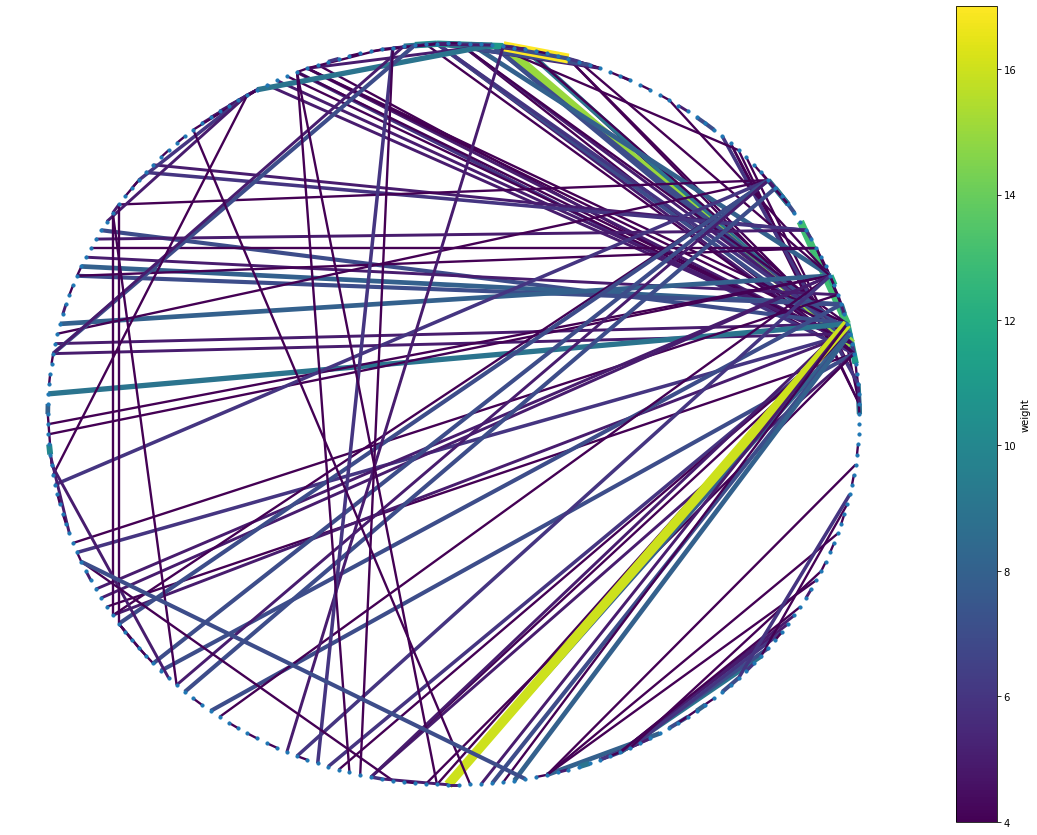

In [41]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_inl_a, votes_a, 4)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=10, pos=nx.circular_layout(G_int_w))

a lot more than on strache day. Maybe most people read the post on the next day as it was posted in the afternoon?

#### 2 days after

In [42]:
postings_inl_a2 = postings_inl.query("'2019-05-19' <= PostingCreatedAt & PostingCreatedAt < '2019-05-20'")
votes_a2 = all_votes.query("'2019-05-19' <= VoteCreatedAt & VoteCreatedAt < '2019-05-20'")

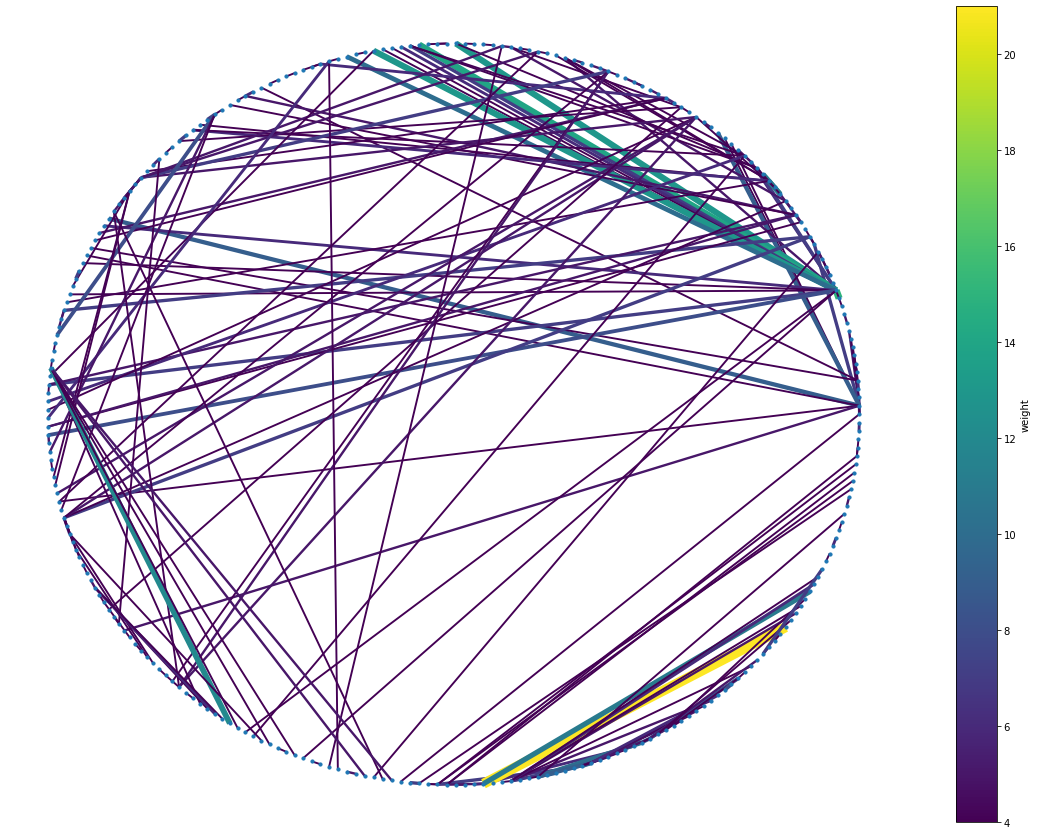

In [43]:
G_int_w = read_graph.get_weighted_interaction_graph(postings_inl_a2, votes_a2, 4)
viz.plot_colored_graph(G_int_w, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=10, pos=nx.circular_layout(G_int_w))

still alot 2 days after (scale goes to 21 compared to 16)

## Compare number of interactions in Inland over time

In [44]:
connections = []
all_postings = []
# 01.05.2019 - 31.05.2019 Inland interactions (comment, like, dislike)
for i in range(0,31):
    startday = "2019-05-{}".format(str(1+i))
    endday = "2019-05-{}".format(str(1+i+1))
    postings = postings_inl.query("'{}' <= PostingCreatedAt & PostingCreatedAt < '{}'".format(startday,endday))
    votes = all_votes.query("'{}' <= VoteCreatedAt & VoteCreatedAt < '{}'".format(startday,endday))
    G = read_graph.get_all_users_interactions(postings, votes, multi_di_graph=True)
    connections.append(len(G.edges))
    all_postings.append(len(postings))

Text(0.5, 1.0, 'Interaction in Inland posts from 01.05.2019 until 31.05.2019')

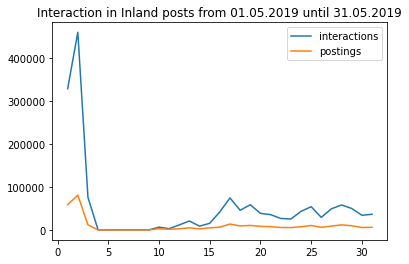

In [45]:
plt.plot(list(range(1,32)), connections)
plt.plot(list(range(1,32)), all_postings)
plt.legend(["interactions","postings"])
plt.title("Interaction in Inland posts from 01.05.2019 until 31.05.2019")

# Compare specific community over time

In [4]:
all_postings.groupby("ID_Article").size().sort_values(ascending=False)[:20]

ID_Article
2000103364196    12042
2000103620997     6375
2000103990942     5173
2000103773909     4789
2000103772847     4290
2000102508150     3987
2000103578888     3918
2000103928932     3748
2000102386715     3582
2000103442116     3312
2000103640150     3269
2000103404528     3258
2000103519155     3164
2000103699010     3148
2000102804423     3118
2000103378024     3115
2000102575048     3085
2000102973603     2876
2000104086108     2875
2000103424380     2776
dtype: int64

In [11]:
postings_video = all_postings.query("ID_Article == '2000103424380'")
G_video = read_graph.get_weighted_interaction_graph(postings_video, all_votes, 2)

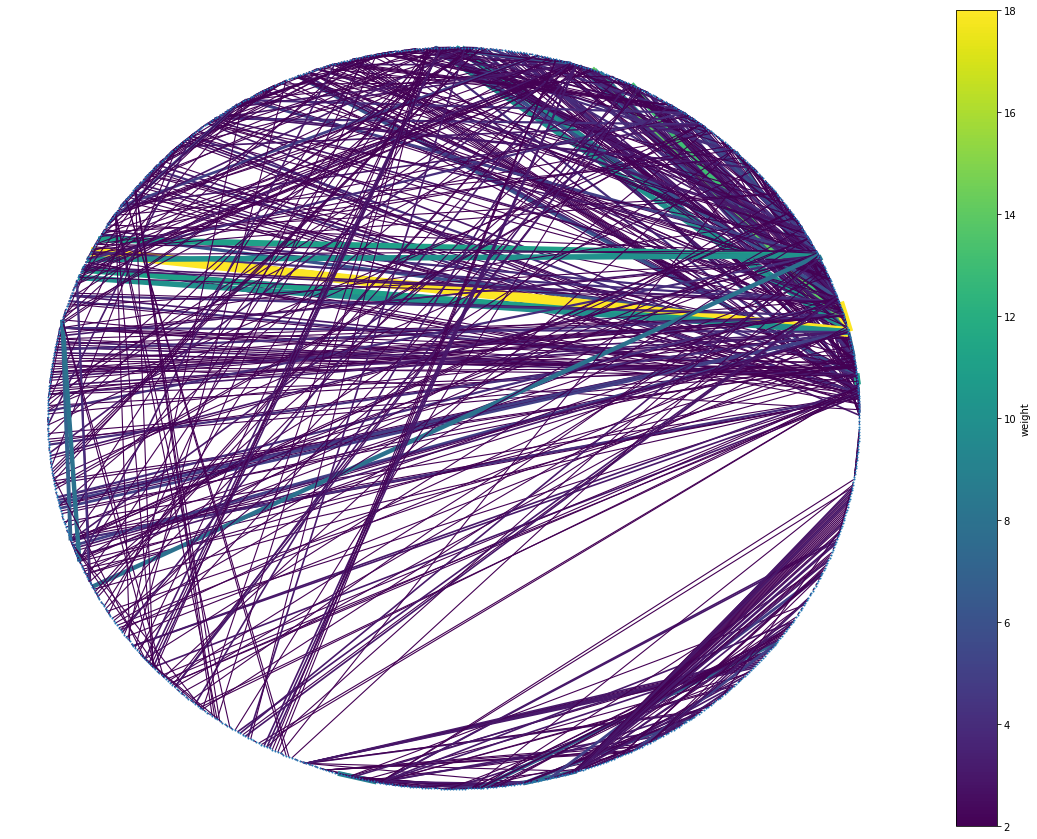

In [12]:
viz.plot_colored_graph(G_video, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=1, pos=nx.circular_layout(G_video))

In [13]:
communities = utils.get_communities(G_video, min_size=2)
len(communities), len(communities[0])

(70, 68)

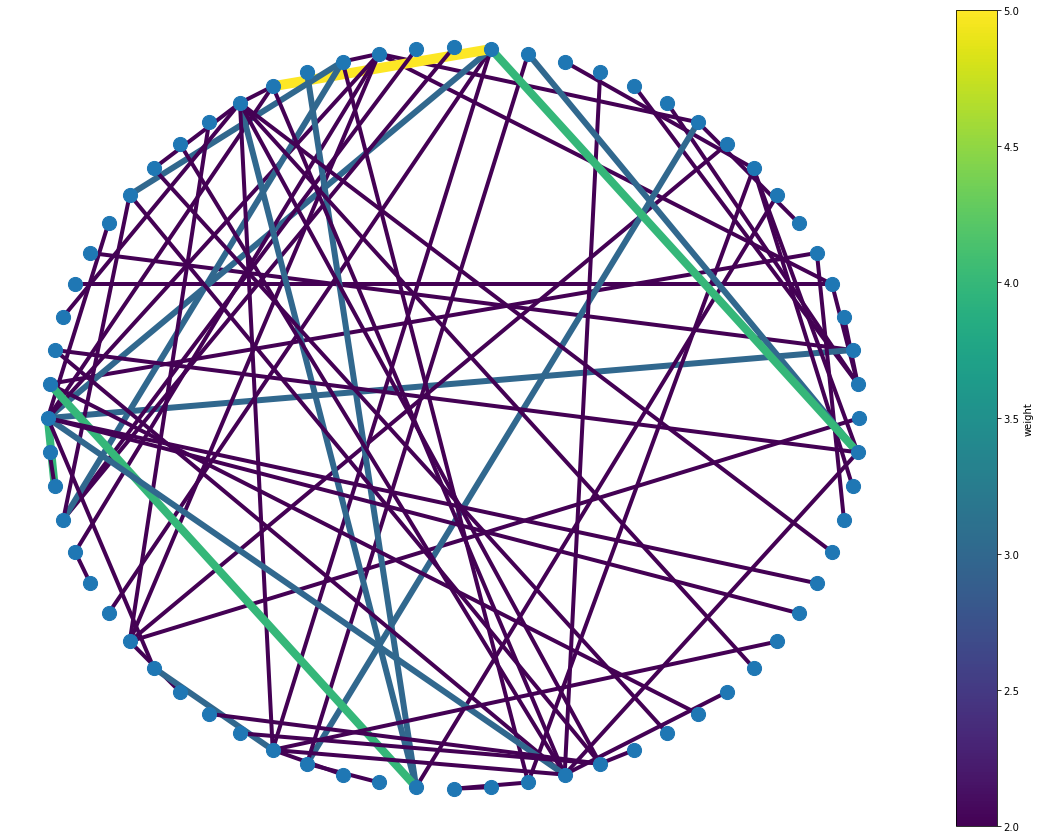

In [14]:
G_video_0 = G_video.subgraph(communities[0])
viz.plot_colored_graph(G_video_0, edge_color_attr="weight", edge_width_factor=10, figsize=(20, 15), node_size=200, pos=nx.circular_layout(G_video_0))

In [59]:
Gs_0 = utils.generate_snapshots_over_time(postings_video, all_votes, communities[0], interval=4, unit="h", max_snapshots=5)
Gs_1 = utils.generate_snapshots_over_time(postings_video, all_votes, communities[1], interval=4, unit="h", max_snapshots=5)
Gs = Gs_0 + Gs_1

2019-05-19 19:51:11.550000
2019-05-19 23:51:11.550000
2019-05-20 03:51:11.550000
2019-05-20 07:51:11.550000
2019-05-20 11:51:11.550000
2019-05-19 19:06:39.340000
2019-05-19 23:06:39.340000
2019-05-20 03:06:39.340000
2019-05-20 07:06:39.340000
2019-05-20 11:06:39.340000


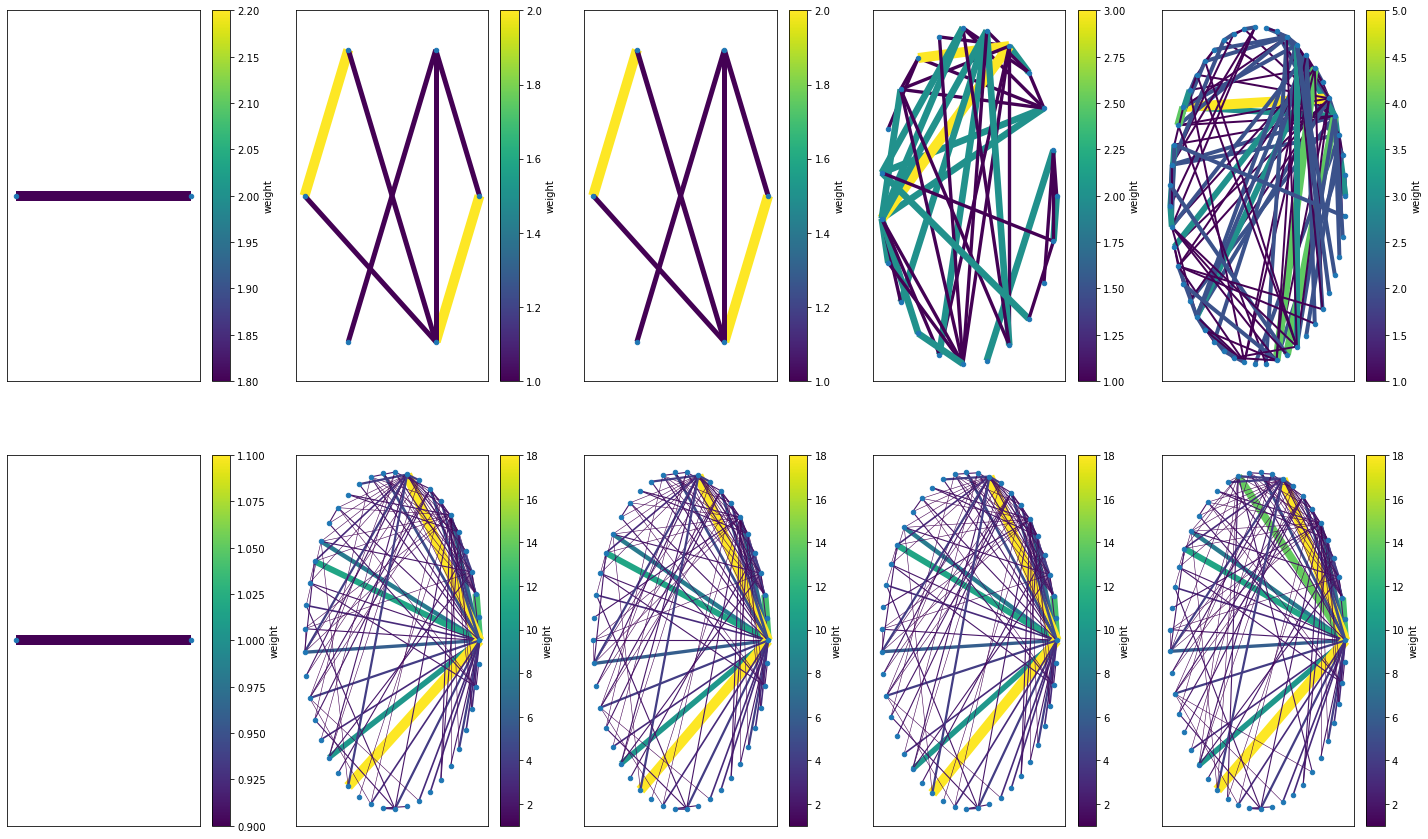

In [60]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharey=True, figsize=(25, 15))
for i, ax_i in enumerate(ax):
    for j, ax_j in enumerate(ax_i):
        G = Gs[i * 5 + j]
        viz.plot_colored_graph(G, edge_color_attr="weight", edge_width_factor=10, node_size=20, pos=nx.circular_layout(G), ax=ax_j)